# Assignment 1
This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.

### Environment setup

The following code reads the train and test data (provided along with this template) and outputs the data and labels as numpy arrays. Use these variables in your code.

---
#### Note on conventions
In mathematical notation, the convention is tha data matrices are column-indexed, which means that a input data $x$ has shape $[d, n]$, where $d$ is the number of dimensions and $n$ is the number of data points, respectively.

Programming languages have a slightly different convention. Data matrices are of shape $[n, d]$. This has the benefit of being able to access the ith data point as a simple `data[i]`.

What this means is that you need to be careful about your handling of matrix dimensions. For example, while the covariance matrix (of shape $[d,d]$) for input data $x$ is calculated as $(x-u)(x-u)^T$, while programming you would do $(x-u)^T(x-u)$ to get the correct output shapes.

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

def read_data(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    num_points = len(lines)
    dim_points = 28 * 28
    data = np.empty((num_points, dim_points))
    labels = np.empty(num_points)
    
    for ind, line in enumerate(lines):
        num = line.split(',')
        labels[ind] = int(num[0])
        data[ind] = [ int(x) for x in num[1:] ]
        
    return (data, labels)

train_data, train_labels = read_data("sample_train.csv")
test_data, test_labels = read_data("sample_test.csv")
print(train_data.shape, test_data.shape)
print(train_labels.shape, test_labels.shape)

(6000, 784) (1000, 784)
(6000,) (1000,)


# Questions
---
## 1.3.1 Representation
The next code cells, when run, should plot the eigen value spectrum of the covariance matrices corresponding to the mentioned samples. Normalize the eigen value spectrum and only show the first 100 values.

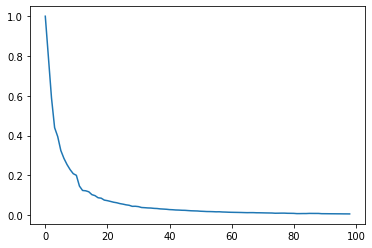

In [31]:
# Samples corresponding to the last digit of your roll number (plot a)
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

a=[]
for i in range(train_labels.shape[0]):
    if (train_labels[i]==4):
        a=np.concatenate((a,train_data[i]),axis=0)


rows= int (np.round(a.shape[0]/784))
a=np.reshape(a,(rows,784))
c=np.cov(a.T)
w,v=LA.eig(c)
w[:]=(w[:]-np.min(w))/(np.max(w)-np.min(w))
plt.plot(w[0:99])
plt.show()

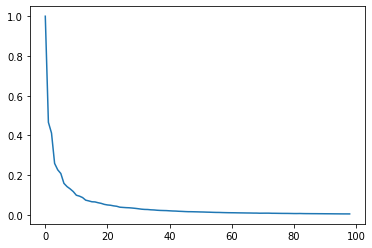

In [32]:
# Samples corresponding to the last digit of (your roll number + 1) % 10 (plot b)

import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

a=[]
for i in range(train_labels.shape[0]):
    if (train_labels[i]==5):
        a=np.concatenate((a,train_data[i]),axis=0)


rows= int (np.round(a.shape[0]/784))
a=np.reshape(a,(rows,784))
c=np.cov(a.T)
w,v=LA.eig(c)
w[:]=(w[:]-np.min(w))/(np.max(w)-np.min(w))
plt.plot(w[0:99])
plt.show()

c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


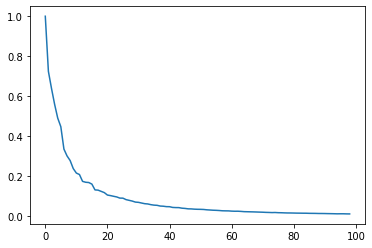

In [3]:
# All training data (plot c)

import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

a=[]
for i in range(train_labels.shape[0]):
    
        a=np.concatenate((a,train_data[i]),axis=0)


rows= int (np.round(a.shape[0]/784))
a=np.reshape(a,(rows,784))
c=np.cov(a.T)
w,v=LA.eig(c)
w[:]=(w[:]-np.min(w))/(np.max(w)-np.min(w))
plt.plot(w[0:99])
plt.show()

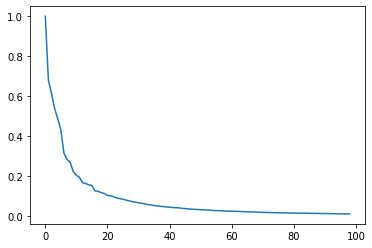

In [5]:
# Randomly selected 50% of the training data (plot d)

import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

a=train_data[np.random.choice(train_data.shape[0],3000,replace=False),:]

c=np.cov(a.T)
w,v=LA.eig(c)
w[:]=(w[:]-np.min(w))/(np.max(w)-np.min(w))
plt.plot(w[0:99])
plt.show()


### 1.3.1 Question 1
- Are plots a and b different? Why?
- Are plots b and c different? Why?
- What are the approximate ranks of each plot?

---
Your answers here (double click to edit)

---

### 1.3.1 Question 2
- How many possible images could there be?
- What percentage is accessible to us as MNIST data?
- If we had acces to all the data, how would the eigen value spectrum of the covariance matrix look?

---
Your answers here (double click to edit)

Q: How many possible images could there be?
A: 2^784

Q:What percentage is accessible to us as MNIST data?
A: (7000*100)/(2^784)

---

## 1.3.2 Linear Transformation
---
### 1.3.2 Question 1
How does the eigen spectrum change if the original data was multiplied by an orthonormal matrix? Answer analytically and then also validate experimentally.

---
Analytical answer here (double click to edit)

---

c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


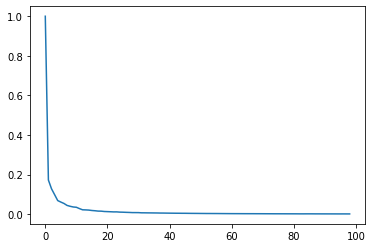

In [3]:
# Experimental validation here.
# Multiply your data (train_data) with an orthonormal matrix and plot the
# eigen value specturm of the new covariance matrix.

# code goes here

import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

A=[]
for i in range(train_labels.shape[0]):
    if (train_labels[i]==4):
        A=np.concatenate((A,train_data[i]),axis=0)


rows= int (np.round(A.shape[0]/784))
A=np.reshape(A,(rows,784))

n= 784

H = np.random.rand(n, n)
u, s, vh = np.linalg.svd(H, full_matrices=False)
mat = u @ vh

B=mat @ mat.T

C=[]

C=[[sum(a * b for a, b in zip(A_row, B_col))  
                        for B_col in zip(*B)] 
                                for A_row in A] 
cov_mat=np.cov(C)
w,v=LA.eig(cov_mat)
w[:]=(w[:]-np.min(w))/(np.max(w)-np.min(w))
plt.plot(w[0:99])
plt.show()

### 1.3.2 Question 2
If  samples  were  multiplied  by  784 × 784  matrix  of rank 1 or 2, (rank deficient matrices), how will the eigen spectrum look like?

---
Your answer here (double click to edit)

---

### 1.3.2 Question 3
Project the original data into the first and second eigenvectors and plot in 2D

c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


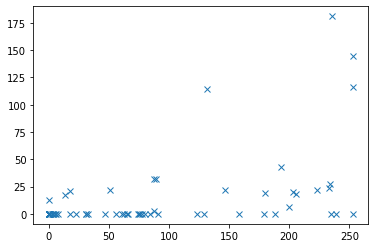

In [5]:
# Plotting code here

import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

A=[]
for i in range(train_labels.shape[0]):
    
        A=np.concatenate((A,train_data[i]),axis=0)


rows= int (np.round(A.shape[0]/784))
A=np.reshape(A,(rows,784))
D=A.T
c=np.cov(D)
w,v=LA.eig(c)

v1=v[0]
v2=v[1]
v_new=np.concatenate((v1,v2),axis=0).reshape(2,784)

new_mat=np.matmul(v_new,D)


plt.plot(new_mat[0,:],new_mat[1,:],'x')


plt.show()


## 1.3.3 Probabilistic View
---
In this section you will classify the test set by fitting multivariate gaussians on the train set, with different choices for decision boundaries. On running, your code should print the accuracy on your test set.

In [ ]:
# Print accuracy on the test set using MLE

import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
def classify(x,k):    
    mat = []
    for i in range(train_data.shape[0]):
        if train_labels[i]==k:
            mat=np.concatenate((mat,train_data[i]), axis=0)

    row= np.round(mat.shape[0]//784)
    mat=np.reshape(mat,(row,784))
    cov_mat=np.cov(mat.T)
    inv=LA.pinv(cov_mat)
    w, v = LA.eig(cov_mat)
    d=0
    for i in range(w.shape[0]):
        if w[i]!=0:
            d=d + np.log(w[i])
    d=-0.5*d-312.8 
    d=np.real(d)
    z=np.mean(mat, axis = 0)
    a=(x-z).dot(inv).dot((x-z).T)
    return (a+d)

def category(x,t):
    count=0
    val=np.zeros(10)
    for j in range(10):
        val[j]=classify(x,j)
    min=val[0]
    low=0
    for i in range(10):
        if val[i]<min:
            min=val[i]
            low=i
    if t==low:
        count+=1
    return count

count_fin=0
n=int(train_data.shape[0])
for i in range(20):
    t=int(train_labels[i])
    w = category(train_data[i],t)
    count_fin = count_fin + w
accuracy=count_fin/n
print('Accuracy',accuracy)

In [9]:
# Print accuracy on the test set using MAP
# (assume a reasonable prior and mention it in the comments)

In [10]:
# Print accuracy using Bayesian pairwise majority voting method

In [ ]:
# Print accuracy using Simple Perpendicular Bisector majority voting method

import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
def perp_bisector(x,k1,k2):
    mat1 = []
    mat2 = []
    for i in range(train_data.shape[0]):
        if train_labels[i]==k1:
            mat1=np.concatenate((mat1,train_data[i]), axis=0)
        if train_labels[i]==k2:
            mat2=np.concatenate((mat2,train_data[i]), axis=0)
    row1= np.round(mat1.shape[0]//784)
    mat1=np.reshape(mat1,(row,784))
    row2= np.round(mat2.shape[0]//784)
    mat2=np.reshape(mat2,(row,784))
    z1=np.mean(mat1, axis = 0)
    z2=np.mean(mat2, axis = 0)
    v=z2-z1
    w=(z1+z2)/2
    r1=(v.T).dot(z1-w)
    r2=(v.T).dot(z2-w)
    r=(v.T).dot(x-w)
    count=0
    if r*r1>=0:
        return k1
    elif r*r2>=0:
        return k2
         
count=0   
n=int(train_data.shape[0])
for i in range(0,n):
    val=np.zeros(10)
    for k1 in range(10):
        for k2 in range(k1):
            r = perp_bisector(train_data[i],k1,k2) 
            val[r]+=1
            if r==train_labels[i]:
                count+=1
accuracy=count/6000
print('Accuracy',accuracy) 

### 1.3.3 Question 4
Compare performances and salient observations

---
Your analysis here (double click to edit)

---

## 1.3.4 Nearest Neighbour based Tasks and Design
---
### 1.3.4 Question 1 : NN Classification with various K
Implement a KNN classifier and print accuracies on the test set with K=1,3,7

In [ ]:
# Your code here
# Print accuracies with K = 1, 3, 7

import operator
def distance(val1, val2, n):
    dist = 0
    for i in range(n):
        dist = dist + np.square(val1[i] - val2[i])
    dist = np.sqrt(dist)

    return dist

def KNN(train_data, train_labels, test_data, k):
    train = np.array(train_data)
    new = []
    col = train.shape[1]
    dist = 0
    for i in range(train.shape[0]):
        dist = 0
        dist = distance(test_data, train[i], col)
        new.append((np.array(train[i]), np.array(train_labels[i]), dist))

    new.sort(key = operator.itemgetter(2))
    nn = []
    for i in range(k):
        nn.append(new[i][1])
    return nn

def getClass(nn):

    hash = np.zeros((1,10))
    for i in range(len(nn)):
        hash[0][np.int(nn[i])] += 1
    count = 0
    for i in range(10):
        if hash[0][i] > hash[0][count]:
            count = i
    return count

def accuracy(prediction, original):
    n = len(prediction)
    count = 0
    for i in range(n):
        if prediction[i] == original[i]:
            count = count + 1
    acc = (count/(float(len(prediction))))*100
    print(acc)
    
test_col = train_data.shape[0]
prediction = []
for i in range(2):
    nn = KNN(train_data, train_labels, test_data[0], 3)
    p = getClass(nn)
    prediction.append(p)
accuracy(prediction, test_labels)
print(prediction)



 


### 1.3.4 Question 1 continued
- Why / why not are the accuracies the same?
- How do we identify the best K? Suggest a computational procedure with a logical explanation.

---
Your analysis here (double click to edit)

1. The accuracies are not the same. 
---

### 1.3.4 Question 2 :  Reverse NN based outlier detection
A sample can be thought of as an outlier is it is NOT in the nearest neighbour set of anybody else. Expand this idea into an algorithm.

In [13]:
# This cell reads mixed data containing both MNIST digits and English characters.
# The labels for this mixed data are random and are hence ignored.
mixed_data, _ = read_data("outliers.csv")
print(mixed_data.shape)

(20, 784)


### 1.3.4 Question 3 : NN for regression
Assume that each classID in the train set corresponds to a neatness score as:
$$ neatness = \frac{classID}{10} $$

---
Assume we had to predict the neatness score for each test sample using NN based techiniques on the train set. Describe the algorithm.

---
Your algorithm here (double click to edit)

We would define a neatness score parameter in the accuracy function, where the neatness score shall be defined as specified in the given mathematical expression and consequently define the mean absolute error as a function of the prediction and neatness score.

---

### 1.3.4 Question 3 continued
Validate your algorithm on the test set. This code should print mean absolute error on the test set, using the train set for NN based regression.

In [14]:
# Your code here

import operator
def distance(val1, val2, n):
    dist = 0
    for i in range(n):
        dist = dist + np.square(val1[i] - val2[i])
    dist = np.sqrt(dist)

    return dist

def KNN(train_data, train_labels, test_data, k):
    train = np.array(train_data)
    new = []
    col = train.shape[1]
    dist = 0
    for i in range(train.shape[0]):
        dist = 0
        dist = distance(test_data, train[i], col)
        new.append(((np.array(train[i]), np.array(train_labels[i]), dist)),neatness_score[i])

    new.sort(key = operator.itemgetter(2))
    nn = []
    for i in range(k):
        nn.append(new[i][1])
    return nn

def getClass(nn):

    hash = np.zeros((1,10))
    for i in range(len(nn)):
        hash[0][np.int(nn[i])] += 1
    count = 0
    for i in range(10):
        if hash[0][i] > hash[0][count]:
            count = i
    return count

def accuracy(prediction, original):
    n = len(prediction)
    count = 0
     neatness_score=train_labels/10
    for i in range(n):
        if prediction[i] == original[i]:
            count = count + 1
    acc = (count/(float(len(prediction))))*100
    print(acc)
    
test_col = train_data.shape[0]
prediction = []
for i in range(2):
    nn = KNN(train_data, train_labels, test_data[0], 3)
    p = getClass(nn)
    prediction.append(p)
accuracy(prediction, test_labels)
print(prediction)

def MAE(prediction,neatness_score):
    sum=0
    for i in range(10):
        sum+=(prediction-neatness_score)
    return (sum/10) 


    acc=accuracy(prediction,neatness_score)
    mae = MAE(prediction,neatness_score)
    return acc,mae

acc_1,mae=accuracy(1)
print('For K = 1, Accuracy =',acc_1)
print('MAE =',mae)                           

acc_3,mae=accuracy(3)
print('For K = 3, Accuracy =',acc_3)
print('MAE =',mae)  

acc_7,mae=accuracy(7)
print('For K = 7, Accuracy =',acc_7)
print('MAE =',mae) 



---
# FOLLOW THE SUBMISSION INSTRUCTIONS
---